In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="IDEXBTC", time="2021-01-17 17:00:05", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    df = df[
        (df["time"] >= start) & (df["time"] < end - timedelta(minutes=1))
    ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]
df.head()

,price,qty,time,isBuyerMaker,quote
0,0.000002,155.0,2020-12-18 17:29:11.365,True,0.000233
1,0.000002,67.0,2020-12-18 17:34:30.542,False,0.000101
2,0.000002,1000.0,2020-12-18 17:34:30.542,False,0.001510
3,0.000002,8955.0,2020-12-18 17:34:30.542,False,0.013522
4,0.000002,593.0,2020-12-18 17:34:30.542,False,0.000895


In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]

df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
    # Add BTC slippage
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long
0,2020-12-18 17:29:11.365,0.000002,0.000002,0.000002,0.000002,-155.0,155.0,-0.000233,0.000233,False
1,2020-12-18 17:34:30.542,0.000002,0.000002,0.000002,0.000002,14720.0,14720.0,0.022227,0.022227,True


<h4>Hourly log returns</h4>

In [6]:
df_candles_1h: pd.DataFrame = df_trades.resample(
    on="time", rule="1h", label="left", closed="left"
).agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    vol=("qty_abs", "sum"),
    net_position=("qty_sign", "sum"),
    net_quote=("quote_sign", "sum"),
    quote_vol=("quote_abs", "sum"),
    num_trades=("price_first", "count"),
    num_long_trades=("is_long", "sum")
)

df_candles_1h.head()

,open,close,vol,net_position,net_quote,quote_vol,num_trades,num_long_trades
time,,,,,,,,
2020-12-18 17:00:00,0.000002,0.000002,95152.0,63470.0,0.096351,0.143914,13,6
2020-12-18 18:00:00,0.000002,0.000002,55155.0,-7023.0,-0.010332,0.084062,18,10
2020-12-18 19:00:00,0.000002,0.000002,13974.0,-5600.0,-0.008476,0.021264,13,6
2020-12-18 20:00:00,0.000002,0.000002,423025.0,97945.0,0.162581,0.681276,187,139
2020-12-18 21:00:00,0.000002,0.000002,15244199.0,-1883119.0,-3.472641,29.299649,2083,1179


In [7]:
df_candles_1h["close"] = df_candles_1h["close"].ffill()
df_candles_1h["log_return"] = np.log(df_candles_1h["close"] / df_candles_1h["close"].shift(1))
df_candles_1h = df_candles_1h.iloc[1:]
df_candles_1h = df_candles_1h.reset_index()

df_candles_1h.head(2)

,time,open,close,vol,net_position,net_quote,quote_vol,num_trades,num_long_trades,log_return
0,2020-12-18 18:00:00,0.000002,0.000002,55155.0,-7023.0,-0.010332,0.084062,18,10,0.0
1,2020-12-18 19:00:00,0.000002,0.000002,13974.0,-5600.0,-0.008476,0.021264,13,6,0.0


<h4>Describe log returns</h4>

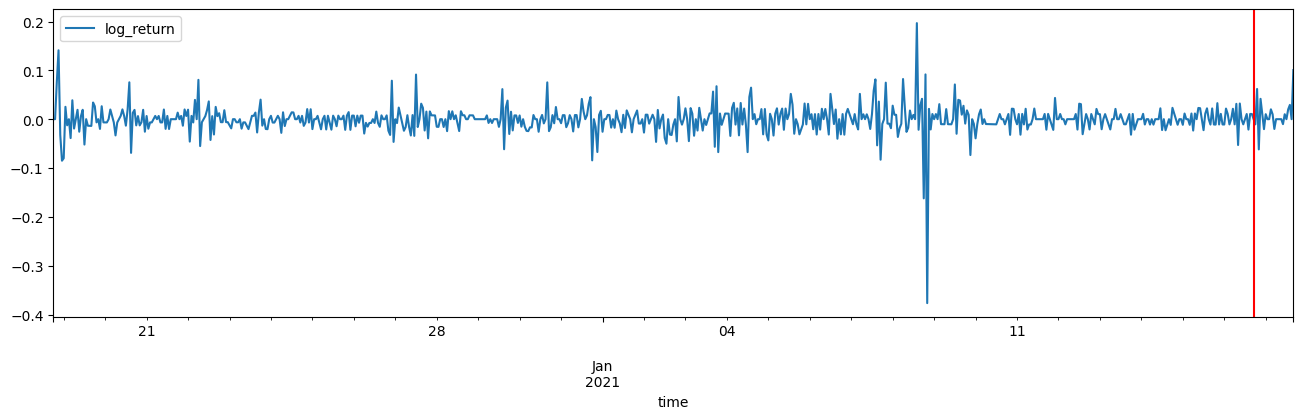

In [8]:
df_candles_1h.plot(x="time", y="log_return", figsize=(16, 4))
plt.axvline(x=pump.time.floor("1h") - timedelta(days=1), color="red")
plt.show()

<h4>Log returns features calculated using windows of various size</h4>

In [9]:
offsets: List[timedelta] = [
    timedelta(days=i) for i in [1, 2, 5, 7, 14, 21, 30]
]

labels: List[str] = [
    "1d", "2d", "5d", "7d", "14d", "21d", "30d"
]

df_population: pd.DataFrame = df_candles_1h[
    df_candles_1h["time"] >= pump.time.floor("1h") - timedelta(days=30)
].copy()


hourly_features: Dict[str, float] = {}


for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_candles_1h[
        (df_candles_1h["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    # Log return features
    hourly_features[f"log_return_1h_z_score_{label}"] = df_interval["log_return"].mean() / df_population["log_return"].std()
    hourly_features[f"log_return_1h_std_{label}"] = df_interval["log_return"].std()
    # Num trades features
    hourly_features[f"z_score_num_trades_1h_{label}"] = df_interval["num_trades"].mean() / df_population["num_trades"].std()
    hourly_features[f"share_empty_trading_hours_{label}"] = df_interval[df_interval["num_trades"] == 0].shape[0] / df_interval.shape[0]
    # Imbalance ratio
    hourly_features[f"imbalance_ratio_1h_{label}"] = df_interval["net_quote"].sum() / df_interval["quote_vol"].sum()

<h4>Powerlaw quote volume</h4>

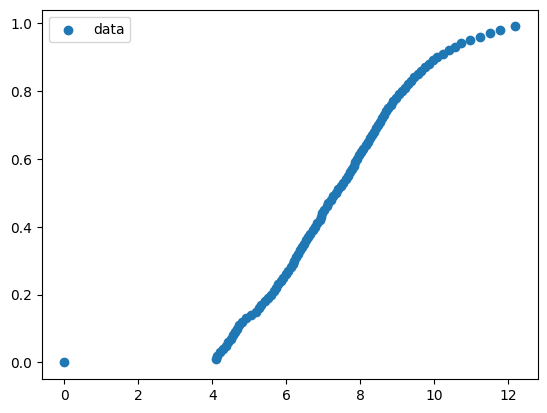

In [10]:
from scipy.stats import powerlaw

alpha = powerlaw.fit(df_trades["quote_abs"])[0]

q = np.arange(0, 1, 0.01)

log_quantiles = np.log(
    np.quantile(df_trades["qty_abs"], q=q)
)

plt.scatter(x=log_quantiles, y=q, label="data")
plt.legend()
plt.show()

In [11]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

X = add_constant(log_quantiles)

model = OLS(endog=q, exog=X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1672.
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           2.15e-63
Time:                        00:37:03   Log-Likelihood:                 127.06
No. Observations:                 100   AIC:                            -250.1
Df Residuals:                      98   BIC:                            -244.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4985      0.025    -19.747      0.0

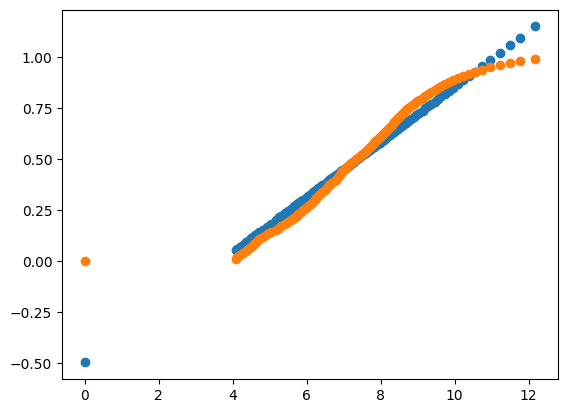

In [12]:
coef, alpha = model.params

Y = coef + alpha * log_quantiles

plt.scatter(x=log_quantiles, y=Y)
plt.scatter(x=log_quantiles, y=q, label="data")
plt.show()

In [13]:
powerlaw_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    # Compute alpha of powerlaw distribution for quote_abs, quote_long, quote_short
    powerlaw_features[f"quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(df_interval["quote_abs"])[0]
    # alpha for long trades
    powerlaw_features[f"long_quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(
        df_interval[df_interval["is_long"]]["quote_abs"]
    )[0]
    # alpha for short trades
    powerlaw_features[f"short_quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(
        df_interval[~df_interval["is_long"]]["quote_abs"]
    )[0]

powerlaw_features

{'quote_abs_powerlaw_alpha_1d': 0.1853973156901225,
 'long_quote_abs_powerlaw_alpha_1d': 0.19696334358380818,
 'short_quote_abs_powerlaw_alpha_1d': 0.1869916915670812,
 'quote_abs_powerlaw_alpha_2d': 0.18126034727949844,
 'long_quote_abs_powerlaw_alpha_2d': 0.19223049814018575,
 'short_quote_abs_powerlaw_alpha_2d': 0.18363386305931953,
 'quote_abs_powerlaw_alpha_5d': 0.1797221236934033,
 'long_quote_abs_powerlaw_alpha_5d': 0.1857181495959139,
 'short_quote_abs_powerlaw_alpha_5d': 0.18134639548349035,
 'quote_abs_powerlaw_alpha_7d': 0.14893338325418679,
 'long_quote_abs_powerlaw_alpha_7d': 0.14705668399760427,
 'short_quote_abs_powerlaw_alpha_7d': 0.17731079753325088,
 'quote_abs_powerlaw_alpha_14d': 0.12391735028539821,
 'long_quote_abs_powerlaw_alpha_14d': 0.12433157915736379,
 'short_quote_abs_powerlaw_alpha_14d': 0.15361954217361212,
 'quote_abs_powerlaw_alpha_21d': 0.12383028512342853,
 'long_quote_abs_powerlaw_alpha_21d': 0.12382136208784172,
 'short_quote_abs_powerlaw_alpha_21d':

<h4>Benfard's law pvalue</h4>

In [14]:
from tsfresh.feature_extraction.feature_calculators import benford_correlation
from tsfresh.feature_extraction.feature_calculators import cid_ce


benford_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    # Benford correlation
    benford_features[f"benford_law_correlation_{label}"] = benford_correlation(df_interval["qty_abs"])

In [15]:
benford_features

{'benford_law_correlation_1d': 0.9882496170744576,
 'benford_law_correlation_2d': 0.98221631907226,
 'benford_law_correlation_5d': 0.9795566327881483,
 'benford_law_correlation_7d': 0.9763545982508572,
 'benford_law_correlation_14d': 0.9955331520792758,
 'benford_law_correlation_21d': 0.9955266510354067,
 'benford_law_correlation_30d': 0.9945448296572329}

<h4>Quote qty features</h4>

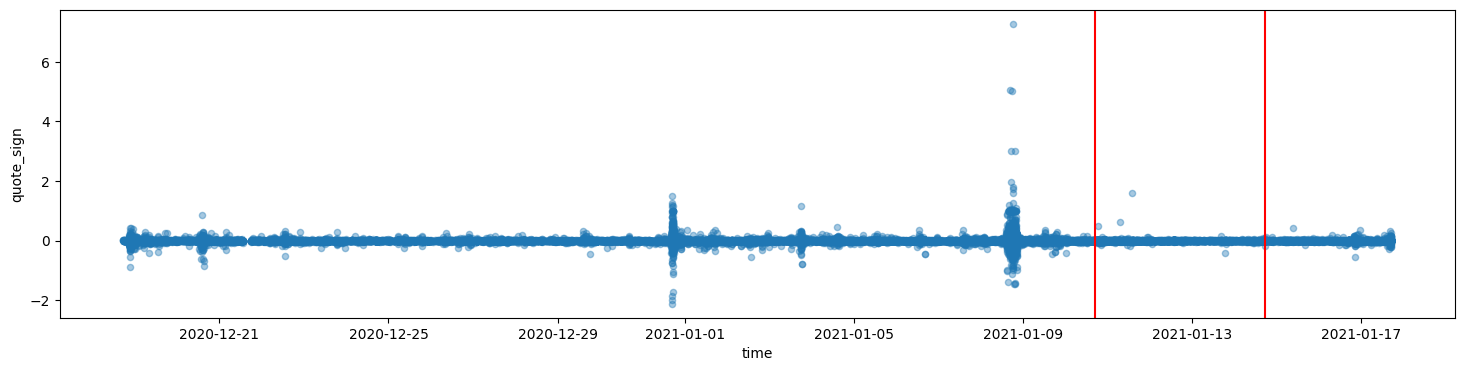

In [16]:
df_trades.plot.scatter(
    x="time", y="quote_sign", figsize=(18, 4), alpha=.4
)

plt.axvline(x=pump.time.floor("1h") - timedelta(days=7), color="red")
plt.axvline(x=pump.time.floor("1h") - timedelta(days=3), color="red")

plt.show()

In [17]:
quote_qty_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[df_trades["time"] >= pump.time.floor("1h") - offset].copy()
    
    long_whale_quantile_999 = df_interval[df_interval["is_long"]]["quote_abs"].quantile(.999)
    short_whale_quantile_999 = df_interval[~df_interval["is_long"]]["quote_abs"].quantile(.999)
    whale_quantile_999 = df_interval["quote_abs"].quantile(.999)
    
    long_whale_quantile_99 = df_interval[df_interval["is_long"]]["quote_abs"].quantile(.99)
    short_whale_quantile_99 = df_interval[~df_interval["is_long"]]["quote_abs"].quantile(.99)
    whale_quantile_999 = df_interval["quote_abs"].quantile(.99)

    long_whale_quantile_95 = df_interval[df_interval["is_long"]]["quote_abs"].quantile(.95)
    short_whale_quantile_95 = df_interval[~df_interval["is_long"]]["quote_abs"].quantile(.95)
    whale_quantile_999 = df_interval["quote_abs"].quantile(.99)


    quote_qty_features[f"long_overall_quantile_999_ratio_{label}"] = long_whale_quantile_999 / whale_quantile_999
    quote_qty_features[f"short_overall_quantile_999_ratio_{label}"] = short_whale_quantile_999 / whale_quantile_999

    quote_qty_features[f"long_quantile_99_999_ratio_{label}"] = long_whale_quantile_999 / long_whale_quantile_99
    quote_qty_features[f"short_quantile_99_999_ratio_{label}"] = short_whale_quantile_999 / short_whale_quantile_99

    quote_qty_features[f"long_quantile_95_99_ratio_{label}"] = long_whale_quantile_95 / long_whale_quantile_99
    quote_qty_features[f"short_quantile_95_99_ratio_{label}"] = short_whale_quantile_95 / short_whale_quantile_99


quote_qty_features

{'long_overall_quantile_999_ratio_1d': 1.827974289570696,
 'short_overall_quantile_999_ratio_1d': 1.9813020526877498,
 'long_quantile_99_999_ratio_1d': 1.954755076505406,
 'short_quantile_99_999_ratio_1d': 1.9482311166591724,
 'long_quantile_95_99_ratio_1d': 0.37728058793360275,
 'short_quantile_95_99_ratio_1d': 0.3395672394279344,
 'long_overall_quantile_999_ratio_2d': 1.9720889876060819,
 'short_overall_quantile_999_ratio_2d': 1.7754457209680814,
 'long_quantile_99_999_ratio_2d': 2.0325592602871274,
 'short_quantile_99_999_ratio_2d': 1.791804357516099,
 'long_quantile_95_99_ratio_2d': 0.3148377550880967,
 'short_quantile_95_99_ratio_2d': 0.35962966209908903,
 'long_overall_quantile_999_ratio_5d': 2.410509105794876,
 'short_overall_quantile_999_ratio_5d': 2.376908960309062,
 'long_quantile_99_999_ratio_5d': 2.504924078867129,
 'short_quantile_99_999_ratio_5d': 2.3652444486503432,
 'long_quantile_95_99_ratio_5d': 0.26983988548342197,
 'short_quantile_95_99_ratio_5d': 0.3237000614085208

<h4>Small timeframe features</h4>

<p>Study pumps on a smaller timeframe. 1 day until the pump</p>

In [18]:
df_trades_1d: pd.DataFrame = df_trades[
    df_trades["time"] >= pump.time.floor("1h") - timedelta(days=1)
].copy()

df_trades_1d["quote_sign_quantile_999"] = df_trades_1d.rolling(on="time", window="1h")["quote_sign"].quantile(.999)
df_trades_1d.head()

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long,quote_sign_quantile_999
52298,2021-01-16 17:00:11.733,9.500000e-07,9.500000e-07,9.500000e-07,9.500000e-07,500.0,500.0,0.000475,0.000475,True,0.000475
52299,2021-01-16 17:00:55.384,9.500000e-07,9.600000e-07,9.600000e-07,9.500000e-07,24446.0,24446.0,0.023341,0.023341,True,0.023318
52300,2021-01-16 17:00:56.154,9.600000e-07,9.600000e-07,9.600000e-07,9.600000e-07,27557.0,27557.0,0.026455,0.026455,True,0.026448
52301,2021-01-16 17:00:56.951,9.600000e-07,9.700000e-07,9.700000e-07,9.600000e-07,26718.0,26718.0,0.025857,0.025857,True,0.026453
52302,2021-01-16 17:00:57.776,9.700000e-07,9.700000e-07,9.700000e-07,9.700000e-07,17840.0,17840.0,0.017305,0.017305,True,0.026452


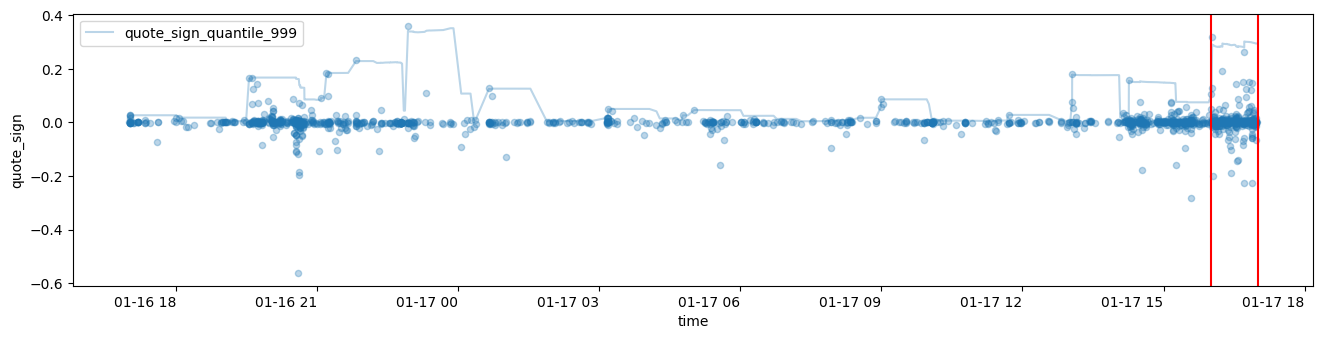

In [19]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)

df_trades_1d.plot(x="time", y="quote_sign_quantile_999", figsize=(16, 4), alpha=.3, ax=ax)
df_trades_1d.plot.scatter(x="time", y="quote_sign", figsize=(16, 4), alpha=.3, ax=ax)

plt.axvline(x=pump.time, color="red")
plt.axvline(x=pump.time - timedelta(hours=1), color="red")
plt.show()

In [20]:
hour_bins: List[int] = [1, 4, 8, 12]

offsets: List[timedelta] = [
    timedelta(hours=i) for i in hour_bins
]

labels: List[str] = [
    f"{i}h" for i in hour_bins
]

df_candles_1h_1d: pd.DataFrame = df_candles_1h[
    df_candles_1h["time"] >= pump.time.floor("1h") - timedelta(days=1)
].copy()

num_trades_1d: int = df_candles_1h_1d["num_trades"].sum()
quote_vol_1d: int = df_candles_1h_1d["quote_vol"].sum()
num_long_trades_1d: int = df_candles_1h_1d["num_long_trades"].sum()

short_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_candles_1h[df_candles_1h["time"] >= pump.time.floor("1h") - offset].copy()
    short_features[f"num_trades_{label}_1d_ratio"] = df_interval["num_trades"].sum() / num_trades_1d
    short_features[f"quote_vol_{label}_1d_ratio"] = df_interval["quote_vol"].sum() / quote_vol_1d
    short_features[f"long_num_trades_{label}_1d_ratio"] = df_interval["num_long_trades"].sum() / num_long_trades_1d

short_features

{'num_trades_1h_1d_ratio': 0.28200253485424587,
 'quote_vol_1h_1d_ratio': 0.32827493569735916,
 'long_num_trades_1h_1d_ratio': 0.3209580838323353,
 'num_trades_4h_1d_ratio': 0.4841571609632446,
 'quote_vol_4h_1d_ratio': 0.5103727041880172,
 'long_num_trades_4h_1d_ratio': 0.5245508982035928,
 'num_trades_8h_1d_ratio': 0.5462610899873257,
 'quote_vol_8h_1d_ratio': 0.535421588320031,
 'long_num_trades_8h_1d_ratio': 0.5760479041916168,
 'num_trades_12h_1d_ratio': 0.6128010139416984,
 'quote_vol_12h_1d_ratio': 0.5836770789255091,
 'long_num_trades_12h_1d_ratio': 0.6538922155688622}